In [1]:
#!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import LabelEncoder

In [4]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#load the dataset
df = pd.read_csv(r"cirrhosis.csv")

In [6]:
df = df.copy()

In [7]:
from sklearn.impute import KNNImputer

In [8]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder



# List of categorical columns (excluding numerical ones)
categorical_cols = ['Status', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Sex']
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Check if there are any numerical columns
if not numerical_cols:
    print("No numerical columns found in the DataFrame.")
else:
    # Identify columns with missing values that are numerical
    numerical_cols_with_missing = df[numerical_cols].columns[df[numerical_cols].isnull().any()].tolist()

    # Print the numerical columns with missing values
    print("Numerical columns with missing values:", numerical_cols_with_missing)

    # Impute only numerical data with missing values if any exist
    if numerical_cols_with_missing:
        imputer = KNNImputer(n_neighbors=5)
        df[numerical_cols_with_missing] = imputer.fit_transform(df[numerical_cols_with_missing])
    else:
        print("No numerical columns with missing values to impute.")

# Encode only the categorical columns
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    else:
        print(f"Column '{col}' not found in DataFrame.")

# Optionally, convert encoded labels back to their original form if needed
for col in categorical_cols:
    if col in label_encoders:  # Check if encoder exists
        df[col] = label_encoders[col].inverse_transform(df[col])

# Check the dataset for missing values
print(df.isnull().sum())


Numerical columns with missing values: ['Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
ID               0
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder


In [10]:
# Standardization
numerical_cols = ['Bilirubin', 'Cholesterol', 'Age', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
scaler = StandardScaler()


In [12]:
# Ensure the numerical columns are cast to float before scaling
df[numerical_cols] = df[numerical_cols].astype(float)


In [13]:
df.loc[:, numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [14]:
# One-Hot Encoding for nominal categorical variables
df = pd.get_dummies(df, columns=['Stage', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], drop_first=True)

In [15]:
# Label Encoding for ordinal categorical variables
label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])  # Example if Status is ordinal

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier


In [29]:
# Split classes into separate datasets
class_0 = df[df['Status'] == 0]  # Class 'C'
class_1 = df[df['Status'] == 1]  # Class 'D'
class_2 = df[df['Status'] == 2]  # Class 'CL'

In [31]:
# Select samples for testing
class_0_test = class_0.sample(n=20, random_state=42)
class_1_test = class_1.sample(n=8, random_state=42)
class_2_test = class_2.sample(n=15, random_state=42)

In [33]:
# The remaining samples for training
class_0_train = class_0.drop(class_0_test.index)
class_1_train = class_1.drop(class_1_test.index)
class_2_train = class_2.drop(class_2_test.index)

In [35]:
# Combine test samples
X_test = pd.concat([class_0_test, class_1_test, class_2_test]).drop('Status', axis=1)
y_test = pd.concat([class_0_test, class_1_test, class_2_test])['Status']


In [37]:
# Combine training samples
X_train_original = pd.concat([class_0_train, class_1_train, class_2_train]).drop('Status', axis=1)
y_train_original = pd.concat([class_0_train, class_1_train, class_2_train])['Status']

In [39]:
# Show the class distribution before any resampling
print("Class distribution before any resampling:")
print(y_train_original.value_counts())

Class distribution before any resampling:
Status
0    212
2    146
1     17
Name: count, dtype: int64


In [41]:
# Discard 40% from majority class (class 0)
class_0_train_reduced = class_0_train.sample(frac=0.6, random_state=42)  # Keep 60% of class 0

# Discard 20 samples from class 2
class_2_train_reduced = class_2_train.sample(n=len(class_2_train) - 20, random_state=42)

In [43]:
# Combine reduced class 0 and class 2 with class 1 for training
X_train_reduced = pd.concat([class_0_train_reduced, class_1_train, class_2_train_reduced]).drop('Status', axis=1)
y_train_reduced = pd.concat([class_0_train_reduced, class_1_train, class_2_train_reduced])['Status']

In [45]:
# Show the class distribution after reducing class 0 and discarding 20 samples from class 2
print("\nClass distribution after reducing class 0 and discarding 20 samples from class 2:")
print(y_train_reduced.value_counts())


Class distribution after reducing class 0 and discarding 20 samples from class 2:
Status
0    127
2    126
1     17
Name: count, dtype: int64


In [47]:
# Apply SMOTE to oversample the minority classes
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced, y_train_reduced)


In [49]:
#!pip install tensorflow

Step 1: Define and Train the GAN

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Separate the minority class data
minority_class_label = 1  # Replace with your actual minority class label
X_minority = X_train_reduced[y_train_reduced == minority_class_label]

# Define the GAN components
latent_dim = 100  # Dimension of the latent space

# Generator Model
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation="relu", input_dim=latent_dim),
        layers.Dense(256, activation="relu"),
        layers.Dense(X_minority.shape[1], activation="linear")  # Matches the feature dimension of X_minority
    ])
    return model

# Discriminator Model
def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(256, activation="relu", input_shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # Binary classification (real vs fake)
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Initialize the Generator and Discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(X_minority.shape[1])

# GAN Model
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer="adam", loss="binary_crossentropy")


C:\Users\irumj\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam

In [54]:
from keras.layers import Input

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Use Input layer instead of input_dim in Dense layers
    # Add your layers here
    model.add(Dense(1, activation='sigmoid'))
    return model

Step 2: Train the GAN

In [56]:
# GAN Training Parameters
epochs = 2000
batch_size = 32
display_step = 1000  # Print progress every 1000 epochs
patience = 1000  # Number of epochs to wait for improvement before stopping
best_d_loss = np.inf  # Track best discriminator loss
wait = 0  # Counter for epochs without improvement

# Create and compile the Discriminator once before training
input_dim = X_minority.shape[1]  # Get the number of features
discriminator = build_discriminator(input_dim)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Training loop
for epoch in range(epochs):
    # Train Discriminator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_samples = generator.predict(noise)

    # Randomly select real data, ensuring we don't exceed the dataset size
    real_indices = np.random.randint(0, X_minority.shape[0], min(batch_size, X_minority.shape[0]))
    real_data = X_minority.iloc[real_indices].values  

    # Combine real and generated samples
    X_combined = np.vstack((real_data, generated_samples)).astype(np.float32)  
    y_combined = np.array([1] * len(real_data) + [0] * batch_size, dtype=np.float32)  # Adjust y_combined length

    # Train the Discriminator
    d_loss, d_acc = discriminator.train_on_batch(X_combined, y_combined)

    # Check for early stopping
    if d_loss < best_d_loss:
        best_d_loss = d_loss
        wait = 0  # Reset wait counter if improvement
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Train Generator (via GAN model where Discriminator weights are frozen)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    y_gen = np.array([1] * batch_size, dtype=np.float32) 
    g_loss = gan.train_on_batch(noise, y_gen)

    # Print progress
    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Discriminator Loss: {d_loss:.4f}, Accuracy: {d_acc:.4f}, Generator Loss: {g_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

Step 3: Modify Dynamic Sampling with GAN-Based Synthetic Data

In [58]:
# Define ensemble models with hyperparameter grids
models = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 1]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    })
}





In [59]:
# Dynamic Sampling Phase with GAN and Hyperparameter Tuning
def dynamic_sampling_with_gan_tuning(X, y, models, generator, minority_class_label, latent_dim, iterations=5):
    best_model = None
    best_score = 0

    for i in range(iterations):
        print(f"Dynamic Sampling Iteration {i + 1}/{iterations}")

        # Generate synthetic samples using GAN for the minority class
        minority_count = np.sum(y == minority_class_label)
        noise = np.random.normal(0, 1, (minority_count, latent_dim))
        synthetic_minority_samples = generator.predict(noise)
        
        # Combine real and synthetic samples
        X_temp = np.vstack((X[y != minority_class_label], X[y == minority_class_label], synthetic_minority_samples))
        y_temp = np.hstack((y[y != minority_class_label], y[y == minority_class_label], [minority_class_label] * minority_count))

        for model_name, (model, params) in models.items():
            print(f"Training {model_name}...")

            # Train with GridSearchCV
            grid_search = GridSearchCV(model, params, scoring='f1_weighted', cv=3, n_jobs=-1)
            grid_search.fit(X_temp, y_temp)

            # Check for the best score
            if grid_search.best_score_ > best_score:
                best_model = grid_search.best_estimator_
                best_score = grid_search.best_score_
                print(f"Best Score: {best_score:.4f} with parameters: {grid_search.best_params_}")

    return best_model



In [60]:
# Apply GAN-based sampling and tuning to get the best model
best_model_dynamic = dynamic_sampling_with_gan_tuning(
    X_train_reduced, 
    y_train_reduced, 
    models, 
    generator,               # Trained GAN generator model
    minority_class_label=minority_class_label,   
    latent_dim=latent_dim,
    iterations=5
)

Dynamic Sampling Iteration 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Training RandomForest...
Best Score: 0.7813 with parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training GradientBoosting...
Best Score: 0.7828 with parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Training AdaBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training XGBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Dynamic Sampling Iteration 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Training RandomForest...
Training GradientBoosting...
Training AdaBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training XGBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Dynamic Sampling Iteration 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Training RandomForest...
Best Score: 0.7847 with parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training GradientBoosting...
Training AdaBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training XGBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Dynamic Sampling Iteration 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Training RandomForest...
Training GradientBoosting...
Training AdaBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training XGBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Dynamic Sampling Iteration 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Training RandomForest...
Best Score: 0.7848 with parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training GradientBoosting...
Training AdaBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training XGBoost...


C:\Users\irumj\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [61]:
# Train the best model on the full training data after GAN-based resampling
best_model_dynamic.fit(X_train_reduced, y_train_reduced)



RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [62]:
# Predictions on the test set
y_pred = best_model_dynamic.predict(X_test)


In [63]:
# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Confusion Matrix:
[[20  0  0]
 [ 4  0  4]
 [ 6  0  9]]


In [64]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Classification Report:
              precision    recall  f1-score   support

           C       0.67      1.00      0.80        20
          CL       0.00      0.00      0.00         8
           D       0.69      0.60      0.64        15

    accuracy                           0.67        43
   macro avg       0.45      0.53      0.48        43
weighted avg       0.55      0.67      0.60        43



C:\Users\irumj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\irumj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\irumj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


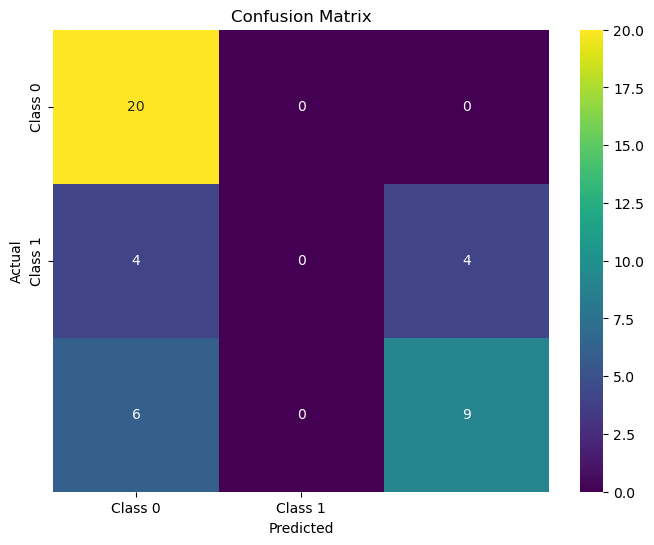

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


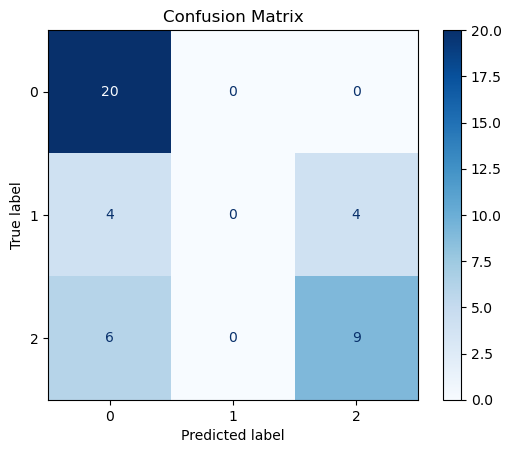

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming y_test and y_pred are already defined
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

# Customizations
plt.title('Confusion Matrix')
plt.show()

In [66]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6744
